# Imports and initialization

we work from the github repo

In [ ]:
cd ..

In [2]:
root_dir = './'
graph_dir = root_dir + 'graphs'
results_dir =  root_dir + 'data/' 

In [3]:
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import linregress
import os
import matplotlib
import joblib
import sys
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize
from matplotlib.legend_handler import HandlerBase
from matplotlib.ticker import (LogLocator, MultipleLocator, AutoMinorLocator)

from codes.functions import *

In [4]:
golden = (1 + 5 ** 0.5) / 2 # golden ratio
cm = 1/2.54  # centimeters in inches

In [5]:
def set_params_figures(figsize=(8,5), labelsize=20, titlesize=20, ticks_labelsize=20, legend_fontsize=20):
    """ Default parameters in the figures
    - figsize = (8,5)
    - labelsize = 22
    - titlesize = 25
    - ticks_labelsize = 18
    - legend_fontsize = 18
    """
    plt.style.use("default")

    params_default = {
        # no upper and right axes
        'axes.spines.right' : True,
        'axes.spines.top' : True,
        # no frame around the legend
        "legend.frameon" : False,

        # dimensions of figures and labels
        'figure.figsize' : figsize,
        'axes.labelsize' : labelsize,
        'axes.titlesize' : titlesize,
        'xtick.labelsize' : ticks_labelsize,
        'ytick.labelsize' : ticks_labelsize,
        'xtick.top' : True,
        'ytick.right' : True,
        'legend.fontsize' : legend_fontsize,
        # no grids
        'axes.grid' : False,

        # the default color(s) for lines in the plots: in order if multiple lines. We can change them or add colors if needed
        # 'axes.prop_cycle' : mpl.cycler(color=["#00008B", "#BF0000", "#006400"]), 

        # default quality of the plot. Not too high but neither too low
        "savefig.dpi" : 300,
        "savefig.bbox" : 'tight', 

        'mathtext.fontset': 'stix',
        'font.family': 'STIXGeneral',
        'font.weight':"bold",
    }


    plt.rcParams['image.cmap'] = 'gray'
    
    
    plt.rcParams.update(params_default)

Text(0, 0.5, '$y$')

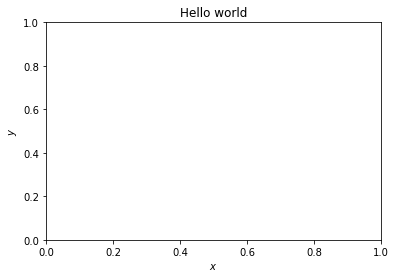

In [6]:
# ACHTUNG: Run this mock figure with latex symbol in labels before running set_params_figures()
# For some reason, I have to do a figure before setting the parameters, 
# otherwise the math latex labels/legend in the plots are also bold, even if the normal text in the same labels is not bold
plt.figure()
plt.title("Hello world")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

In [7]:
# ACHTUNG: Run previous cell (mock figure with latex symbol in labels) before running set_params_figures()
set_params_figures()

In [8]:
markers = ["v", "^", "s", "$\clubsuit$", "$\spadesuit$", "$\diamondsuit$","*", "P", "X", "."]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [9]:
class continuous_and_dashed_line_handle(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        if orig_handle[2]:
            l1 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height],
                               linestyle=orig_handle[1], color=orig_handle[0])
            l2 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height], 
                               color=orig_handle[0])
            return [l1, l2]
        else:
            l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height],
                               linestyle=orig_handle[1], color=orig_handle[0])
            return [l1]

class line_and_filled_handle(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
            l1 = plt.Line2D([x0,y0+width], [0.5*height,0.5*height],
                               color=orig_handle[0])
            l2 = plt.Line2D([x0+width*0.1,y0+width*0.9], [0.5*height,0.5*height], 
                               color=orig_handle[1], lw=10)
            return [l1, l2]

In [10]:
def powerLawRegr(seq):
    '''
        Calculates a power law regression of the function y(t) = seq[t], for t from 0.01*len(seq) to len(seq), as a linregress on the loglog scale.
        
        Returns slope, intercept, std_err of the loglog linregress
    '''
    lenD = len(seq)
    if lenD <= 10:
        return 0,0,0
    else:
        lenDInitial = max(1,int(0.01*lenD))
        slope, intercept, r_value, p_value, std_err = linregress(np.log10(np.arange(lenDInitial,lenD)), np.log10(seq[lenDInitial:lenD]))
        return slope, intercept, std_err


def powerLawRegrPoints(xs, ys):
    '''
        Calculates a power law regression of the points xs and ys, which must be of the same size
        This is calculated as a linregress on the loglog scale of the points.
        
        Returns slope, intercept, std_err of the loglog linregress
    '''
    if len(xs) <= 2:
        return 0,0,0
    else:
        xs = np.log10(xs)
        ys = np.log10(ys)
        slope, intercept, r_value, p_value, std_err = linregress(xs, ys)
        return slope, intercept, std_err

# Figure 1 (theoretic values)

## Get graph

Loaded Erdos_Renyi with requested N=100 and average degree avg_k=3.00, actual is N=99 and avg_k=3.27.


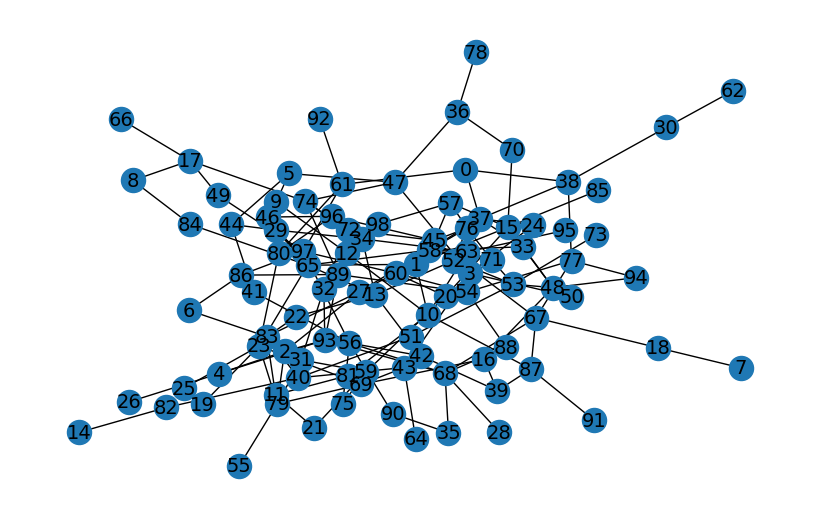

Avg. Degree = 3.2727


In [11]:
N_requested = 100
G, A = load_graph(name_graph = "Erdos_Renyi", N_requested = N_requested, avg_k_requested = 3.00,  # Barabasi_Albert, Erdos_Renyi
    graph_dir = graph_dir, 
    max_tries = 1,
    do_prints = True,
    create_new = True,
    show_graph = True, use_spring_layout=True, use_circular_layout=False, save_fig=False, save_as_pdf=True)
k_list = G.degree() # degree list
print("Avg. Degree = %.4f"%(np.mean(list(dict(k_list).values()))))
e = np.real(np.linalg.eigvals(A)) # eigenvalues
max_eig = max(e) # maximum eigenvalue
expected_entr_prod_theoretic = np.log(max_eig) # expected entropy production rate

N=99, M=162, Avg. Degree=3.2727


Text(0, 0.5, '$p(k)$')

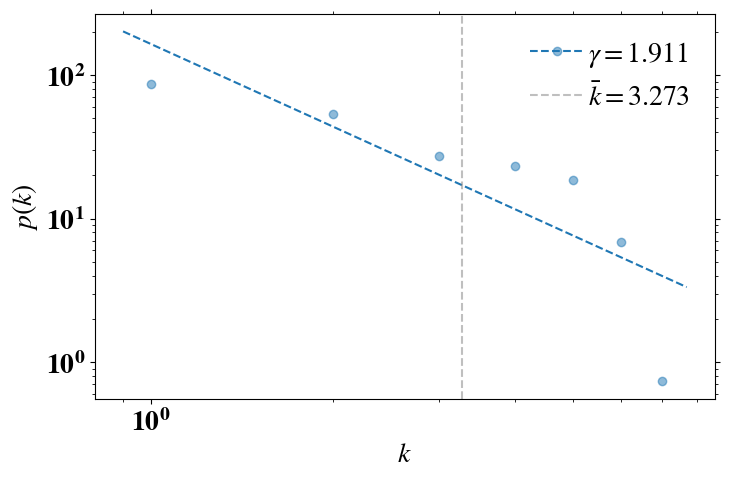

In [12]:
fig = plt.figure()
ax = plt.gca()
print("N=%d, M=%d, Avg. Degree=%.4f"%(len(G),len(G.edges()),np.mean(list(dict(k_list).values()))))
k_array = np.array(list(dict(k_list).values()))
hist_tmp,bins = np.histogram(k_array,bins=np.geomspace(k_array.min(),k_array.max(),10*len(k_array)),density=True)
bins_centers_tmp = np.round(bins[:-1])#(bins[1:] + bins[:-1])/2
hist = []
bins_centers = []
for i,value in enumerate(hist_tmp.copy()):
    if value != 0:
        hist.append(value)
        bins_centers.append(bins_centers_tmp[i])
hist = np.array(hist)
bins_centers = np.array(bins_centers)
slope, intercept, std_err = powerLawRegrPoints(bins_centers, hist)
ax.scatter(bins_centers,hist, color=colors[0],alpha=0.5)
t = np.array([0.9*min(bins_centers),1.1*max(bins_centers)])
ax.plot(t,t**slope * 10**intercept, alpha=1,color=colors[0], ls="--")
label = r"$\gamma=%.3f$"%(np.abs(slope))
label_axvline = r"$\bar{k}=%.3f$"%(np.mean(k_array))
ax.axvline(np.mean(k_array), ls="--",color="gray",alpha=0.5)

leg = ax.legend([plt.plot([],ls="--",marker="o",markerfacecolor=tuple(list(matplotlib.colors.to_rgb(colors[0]))+[0.5]), 
                color=colors[0])[0],
                plt.plot([], ls="--",color="gray",alpha =0.5)[0]],
                [label,label_axvline], handletextpad=0.1, scatterpoints=1,
                fontsize=18, loc='upper right', markerscale=1,
                edgecolor=(0.5, 0.5, 0.5, 1), facecolor=(1, 1, 1, 0.1), prop={'weight':'normal'},
               ) 
ax.loglog()
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$p(k)$")

N=99, M=162, Avg. Degree=3.2727


Text(0, 0.5, '$P(k)$')

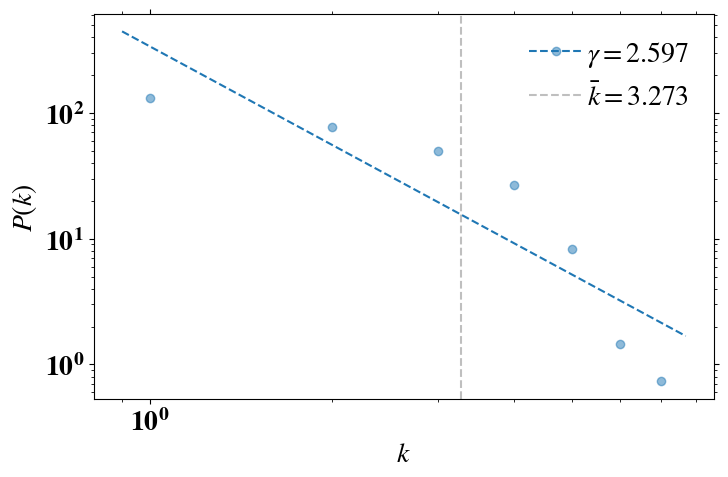

In [13]:
fig = plt.figure()
ax = plt.gca()
print("N=%d, M=%d, Avg. Degree=%.4f"%(len(G),len(G.edges()),np.mean(list(dict(k_list).values()))))
k_array = np.array(list(dict(k_list).values()))
hist_tmp,bins = np.histogram(k_array,bins=np.geomspace(k_array.min(),k_array.max(),10*len(k_array)),density=True)
bins_centers_tmp = np.round(bins[:-1])#(bins[1:] + bins[:-1])/2
hist = []
bins_centers = []
for i,value in enumerate(hist_tmp.copy()):
    if value != 0:
        hist.append(value)
        bins_centers.append(bins_centers_tmp[i])
hist = np.array(hist)
bins_centers = np.array(bins_centers)
# CUMULATIVE SUM!
hist = np.sum(hist)-np.cumsum(hist)+hist[-1]
slope, intercept, std_err = powerLawRegrPoints(bins_centers, hist)
ax.scatter(bins_centers,hist, color=colors[0],alpha=0.5)
t = np.array([0.9*min(bins_centers),1.1*max(bins_centers)])
ax.plot(t,t**slope * 10**intercept, alpha=1,color=colors[0], ls="--")
label = r"$\gamma=%.3f$"%(np.abs(slope))
label_axvline = r"$\bar{k}=%.3f$"%(np.mean(k_array))
ax.axvline(np.mean(k_array), ls="--",color="gray",alpha=0.5)

leg = ax.legend([plt.plot([],ls="--",marker="o",markerfacecolor=tuple(list(matplotlib.colors.to_rgb(colors[0]))+[0.5]), 
                color=colors[0])[0],
                plt.plot([], ls="--",color="gray",alpha =0.5)[0]],
                [label,label_axvline], handletextpad=0.1, scatterpoints=1,
                fontsize=18, loc='upper right', markerscale=1, 
                edgecolor=(0.5, 0.5, 0.5, 1), facecolor=(1, 1, 1, 0.1), prop={'weight':'normal'},
               ) 

ax.loglog()
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$P(k)$")

## Calculate $\Psi$ and $h$

In [14]:
s_list = np.linspace(-2,2,4001)
Psi = np.zeros(len(s_list),dtype=float)

In [15]:
for index,s in tqdm(enumerate(s_list)):
    Pi = normalize(A.copy().astype("float"), axis=1,norm="l1") # transition matrix
    for i,_ in enumerate(Pi):
        for j,pi_ij in enumerate(_):
            # Transform Pi into the tilted matrix
            Pi[i,j] = float(pi_ij) * float(k_list[i])**s 
    Psi[index] = np.log(max(np.abs(np.real(np.linalg.eigvals(Pi)))))

0it [00:00, ?it/s]

In [16]:
# Derivative of Psi
DPsi = np.gradient(Psi,s_list)

In [17]:
h = Psi + (1-s_list)*DPsi

max(h)=1.4801465135938718 at 1.000 (max log(eig) = 1.4801465135938718)


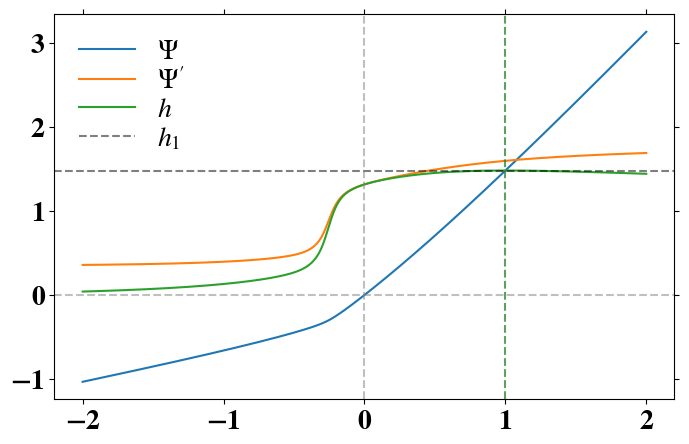

In [18]:
# Plot calculated variables to check they are right
plt.plot(s_list,Psi,label=r"$\Psi$")
plt.plot(s_list,DPsi,label=r"$\Psi'$")
plt.plot(s_list,h,label=r"$h$")
print(r"max(h)=%.16f at %.3f (max log(eig) = %.16f)"%(max(h),s_list[h.argmax()],expected_entr_prod_theoretic))
plt.axhline(0, ls="--", color="gray",alpha=0.5)
plt.axhline(expected_entr_prod_theoretic, ls="--", color="black", label=r"$h_1$",alpha=0.5)
plt.axvline(0, ls="--", color="gray",alpha=0.5)
plt.axvline(1, ls="--", color="gray",alpha=0.5)
plt.axvline(s_list[h.argmax()], ls="--", color="green",alpha=0.5)

plt.legend(prop={"weight":"normal"},labelspacing=0.1)
os.makedirs(root_dir + "figures", exist_ok = True)
plt.savefig(root_dir + f"figures/Fig1_theoretic_variables_psi_N_{N_requested}.pdf",bbox_inches="tight")

In [19]:
DDPsi = np.gradient(DPsi,s_list)

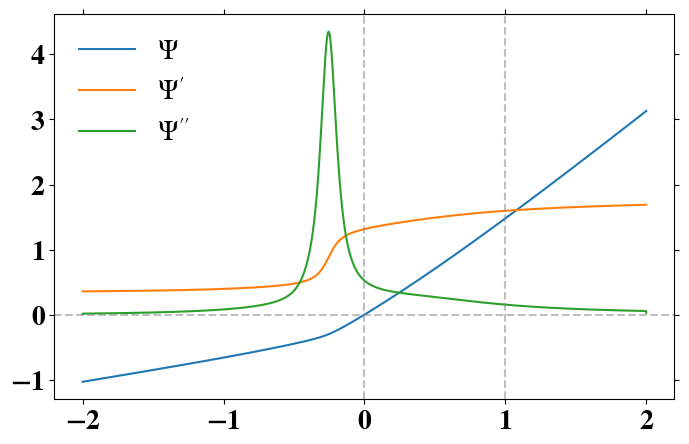

In [20]:
# Plot Psi and its derivatives to check they are right
plt.plot(s_list,Psi,label=r"$\Psi$")
plt.plot(s_list,DPsi,label=r"$\Psi'$")
plt.plot(s_list,DDPsi,label=r"$\Psi''$")
plt.axhline(0, ls="--", color="gray",alpha=0.5)
plt.axvline(0, ls="--", color="gray",alpha=0.5)
plt.axvline(1, ls="--", color="gray",alpha=0.5)

plt.legend(prop={"weight":"normal"})
plt.savefig(root_dir + f"figures/Fig1_theoretic_derivatives_psi_N_%d.pdf"%(N_requested),bbox_inches="tight")

## Plot

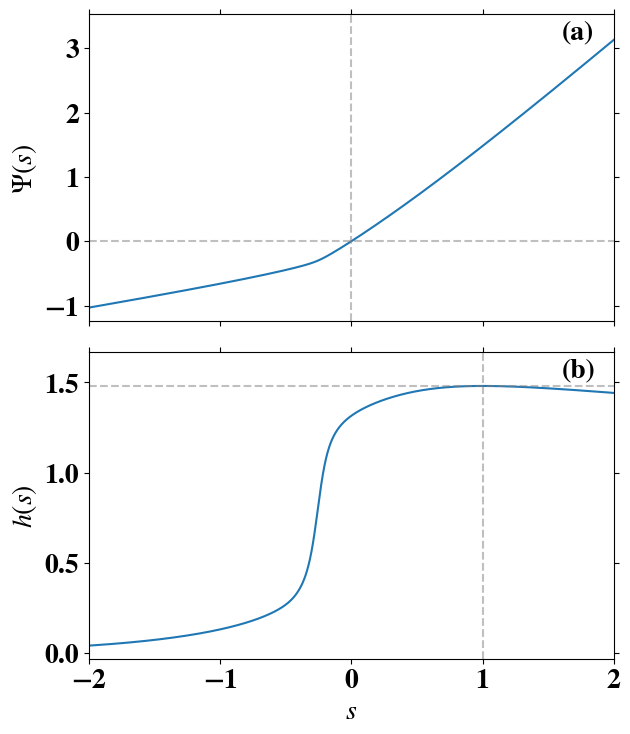

In [21]:
width = 8.6*cm*2
fig, axes = plt.subplots(2,1,figsize=(width,width/golden*2), gridspec_kw={'hspace':.1})

################################## A ##################################
ax = axes[0]

ax.plot(s_list,Psi, alpha=1,color=colors[0])
ax.axhline(0, ls="--", color="gray",alpha=0.5)
ax.axvline(0, ls="--", color="gray",alpha=0.5)

ax.set_xlim([-2,2])
ax.set_ylim(top = Psi.max() + 0.4)
ax.set_ylabel(r"$\Psi(s)$",fontsize=20)

ax.text(0.9, 0.92, "(a)", fontsize=20, transform=ax.transAxes,fontweight="bold")
ax.tick_params(labelbottom = False)

################################## B ##################################
ax = axes[1]

ax.plot(s_list,h, label=r"$h(s)$", alpha=1,color=colors[0])
ax.axhline(expected_entr_prod_theoretic, ls="--", color="gray", label="max",alpha=0.5)
ax.axvline(1, ls="--", color="gray", label="max",alpha=0.5)

ax.set_xlim([-2,2])
ax.set_xlabel(r"$s$",fontsize=20)
ax.set_ylim(top = h.max() + 0.19)
ax.set_ylabel(r"$h(s)$",fontsize=20)

ax.text(0.9, 0.92, "(b)", fontsize=20, transform=ax.transAxes,fontweight="bold")

os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + f"figures/Fig1_theoretic_N_{N_requested}.pdf",bbox_inches="tight")

# Figure 2

## Get data

In [22]:
graphs = {}

N_requested = 1000

for name_graph in ["Erdos_Renyi","Barabasi_Albert","Airports"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    G, A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested,
        graph_dir = graph_dir, 
        max_tries = 1,
        show_graph = False, use_spring_layout=True, use_circular_layout=False, save_fig=False, save_as_pdf=True,
        do_prints = True, create_new = False)
    graphs[name_graph] = G.copy()

Loaded Erdos_Renyi with requested N=1000 and average degree avg_k=3.00, actual is N=962 and avg_k=3.19.
Loaded Barabasi_Albert with requested N=1000 and average degree avg_k=4.00, actual is N=1000 and avg_k=3.99.
Loaded Airports with actual N=3618 and avg_k=7.82.


In [23]:
algorithms = ["URW", "MERW", "ARW"]
entropy_type = 3 # entropy is calculated on the subgraph made by only the explored links
alpha = 0.1 # scaling parameter exponent for ARW

In [24]:
# SINGLE DATA for first row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]

results_fig2 = {}
for name_graph,G in graphs.items():
    results_fig2[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in algorithms:
        print(f"Looking for {name_graph} {algorithm}")
        max_err = 0
        for ID in range(200): # this can be changed
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                if np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100]) > max_err: # this can be changed
                    max_err = np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100])
                    results_fig2[name_graph][algorithm] = tmp
            except FileNotFoundError as e:
                pass

Looking for Erdos_Renyi URW
Looking for Erdos_Renyi MERW
Looking for Erdos_Renyi ARW
Looking for Barabasi_Albert URW
Looking for Barabasi_Albert MERW
Looking for Barabasi_Albert ARW
Looking for Airports URW
Looking for Airports MERW
Looking for Airports ARW


In [25]:
# AVERAGE DATA for second row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]

links_list_results_fig2 = {}
mean_error_results_fig2 = {}
std_error_results_fig2 = {}
q1_error_results_fig2 = {}
q2_error_results_fig2 = {}
q3_error_results_fig2 = {}
num_results_fig2 = {}
finished_results_fig2 = {}

for name_graph,G in graphs.items():
    links_list_results_fig2[name_graph] = {}
    mean_error_results_fig2[name_graph] = {}
    std_error_results_fig2[name_graph] = {}
    q1_error_results_fig2[name_graph] = {}
    q2_error_results_fig2[name_graph] = {}
    q3_error_results_fig2[name_graph] = {}
    num_results_fig2[name_graph] = {}
    finished_results_fig2[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        std_error_results_fig2[name_graph][algorithm] = []
        num_results_fig2[name_graph][algorithm] = 0
        finished_results_fig2[name_graph][algorithm] = 0
        # Loading files
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                links_list_results_fig2[name_graph][algorithm] = tmp["M_list"]
                num_results_fig2[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_results_fig2[name_graph][algorithm] += 1
                # we append the array of all errors into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_error_results_fig2[name_graph][algorithm].append(
                    [
                        (tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] - tmp["empirical_entr_prod_list_M"][entropy_type][i])/tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] 
                        if tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] != 0 else 0 
                        for i in range(len(tmp["maximum_entr_prod_explored_list_M"][entropy_type]))
                    ])
            except FileNotFoundError as e:
                pass
        
        # Calculation of all variables
        mean_error_results_fig2[name_graph][algorithm] = []
        q1_error_results_fig2[name_graph][algorithm] = []
        q2_error_results_fig2[name_graph][algorithm] = []
        q3_error_results_fig2[name_graph][algorithm] = []
        tmp_std = []
        
        for i in range(len(links_list_results_fig2[name_graph][algorithm])):
            mean_error_results_fig2[name_graph][algorithm].append(np.mean(np.array([std_error_results_fig2[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig2[name_graph][algorithm])) if std_error_results_fig2[name_graph][algorithm][ID][i] != -1]))) 
            q1_error_results_fig2[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig2[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig2[name_graph][algorithm])) if std_error_results_fig2[name_graph][algorithm][ID][i] != -1]),25)) 
            q2_error_results_fig2[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig2[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig2[name_graph][algorithm])) if std_error_results_fig2[name_graph][algorithm][ID][i] != -1]),50)) 
            q3_error_results_fig2[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig2[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig2[name_graph][algorithm])) if std_error_results_fig2[name_graph][algorithm][ID][i] != -1]),75)) 
            tmp_std.append(np.std(np.array([std_error_results_fig2[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig2[name_graph][algorithm])) if std_error_results_fig2[name_graph][algorithm][ID][i] != -1])))
            
        mean_error_results_fig2[name_graph][algorithm] = np.array(mean_error_results_fig2[name_graph][algorithm])
        q1_error_results_fig2[name_graph][algorithm] = np.array(q1_error_results_fig2[name_graph][algorithm])
        q2_error_results_fig2[name_graph][algorithm] = np.array(q2_error_results_fig2[name_graph][algorithm])
        q3_error_results_fig2[name_graph][algorithm] = np.array(q3_error_results_fig2[name_graph][algorithm])
        std_error_results_fig2[name_graph][algorithm] = np.array(tmp_std)

        print(f"\t\t FOUND: {num_results_fig2[name_graph][algorithm]}, FINISHED: {finished_results_fig2[name_graph][algorithm]}", flush=True)

Graph Erdos_Renyi, algorithm URW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Erdos_Renyi, algorithm MERW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Erdos_Renyi, algorithm ARW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 870
Graph Barabasi_Albert, algorithm URW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Barabasi_Albert, algorithm MERW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Barabasi_Albert, algorithm ARW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 742
Graph Airports, algorithm URW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Airports, algorithm MERW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 0
Graph Airports, algorithm ARW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 938, FINISHED: 0


In [26]:
# Calculation of max_M based on the max number of links explored in the ARW
max_M = {}
for column,name_graph in enumerate(results_fig2.keys()):
    for algorithm in ["ARW"]:
        if algorithm in results_fig2[name_graph]:
            q1 = q1_error_results_fig2[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            links_list = links_list_results_fig2[name_graph][algorithm][indices]
            max_M[name_graph] = links_list[-1]

## Plot

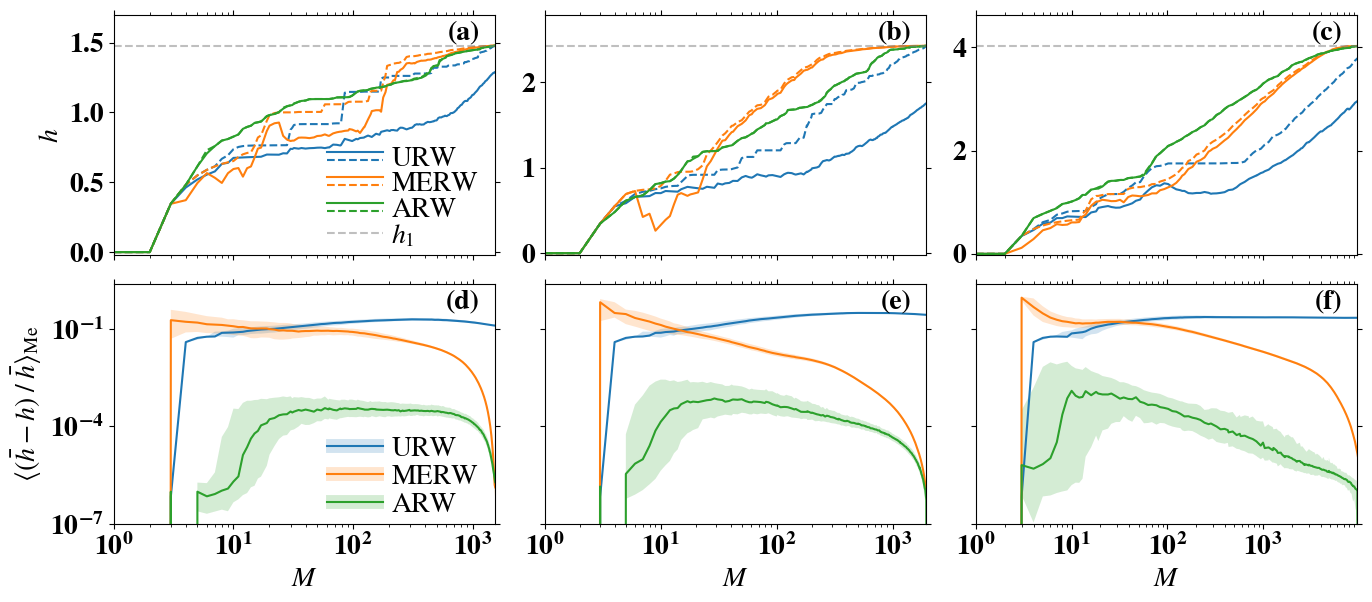

In [27]:
width = 8.6*cm*2
width_fig = width * 2.37
height_fig = width_fig/golden*2/3
num_columns = len(results_fig2.keys())
fig, axes = plt.subplots(2,num_columns,figsize=(width_fig,height_fig), gridspec_kw={'hspace':.12,'wspace':0.13})
counter = -1

############################# FIRST ROW #############################
row = 0 # SINGLE DATA
for column,name_graph in enumerate(results_fig2.keys()):
    counter += 1
    ax = axes[row,column]
    
    for color_id,algorithm in enumerate(algorithms):
        if algorithm in results_fig2[name_graph]:
            tmp = results_fig2[name_graph][algorithm]
            try:
                last_index = list(tmp["maximum_entr_prod_explored_list_M"][entropy_type]).index(-1)
            except ValueError:
                last_index = len(tmp["maximum_entr_prod_explored_list_M"][entropy_type])
            ax.plot(tmp["M_list"][:last_index],tmp["empirical_entr_prod_list_M"][entropy_type][:last_index],label=algorithm, alpha=1,color=colors[color_id])
            ax.plot(tmp["M_list"][:last_index],tmp["maximum_entr_prod_explored_list_M"][entropy_type][:last_index],"--", alpha=1,color=colors[color_id])

    expected_entr_prod = tmp["maximum_entr_prod"]
    ax.axhline(expected_entr_prod, ls="--", color="gray", label="max",alpha=0.5)
    
    ax.set_xscale("log")
    left = 1
    right = max_M[name_graph] 
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_ylim([-0.02,expected_entr_prod*1.15])
     
    if column == 0:
        # Legend only in the first column
        leg = ax.legend([(colors[0],"--",True), (colors[1],"--",True), (colors[2],"--",True), ((0.5,0.5,0.5,0.5),"--",False)], ['URW', "MERW", "ARW",r"$h_1$"],
                               handler_map={tuple: continuous_and_dashed_line_handle()},
                               prop={'weight':'normal'},
                               handletextpad=0.3, 
                               loc='lower right', bbox_to_anchor=(1.02, -0.08), markerscale=1,
                               frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                               labelspacing = 0.,
                               )
        # ylabel only in the first column
        ax.set_ylabel(r"$h$")
    ax.tick_params(labelbottom = False)

    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    ax.xaxis.set_minor_locator(locminX)
    
    
############################# SECOND ROW #############################
row = 1 # AVERAGE DATA
for column,name_graph in enumerate(results_fig2.keys()):
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(algorithms):
        if algorithm in results_fig2[name_graph]:
            q1 = q1_error_results_fig2[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            almost_0 = 0
            links_list = links_list_results_fig2[name_graph][algorithm]
            mean_list = np.array([mean_error_results_fig2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            std_list = np.array([std_error_results_fig2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q1 = np.array([q1_error_results_fig2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q2 = np.array([q2_error_results_fig2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q3 = np.array([q3_error_results_fig2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            ax.plot(links_list,q2,label=algorithm, alpha=1,color=colors[color_id])
            ax.fill_between(links_list, q1, q3, color=colors[color_id], alpha = 0.2,lw=0)
    
    ax.axhline(0, ls="--", color="gray")
    ax.set_xscale("log")
    ax.set_xlabel(r"$M$")
    left = 1
    right = max_M[name_graph] # max_M # int(max(links_list)+1)
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ylim = list(ax.get_ylim())
    ax.set_yscale("log")
    ax.set_ylim(top = 2.5, bottom = 1e-7)

    if column == 0:
        # Legend only in the first column
        leg = ax.legend([(colors[0],matplotlib.colors.to_rgba(colors[0], 0.2)), (colors[1],matplotlib.colors.to_rgba(colors[1], 0.2)), (colors[2],matplotlib.colors.to_rgba(colors[2], 0.2))], ['URW', "MERW", "ARW"],
                               handler_map={tuple: line_and_filled_handle()},
                        handletextpad=0.3, 
                               loc='lower right', bbox_to_anchor=(1.02, -0.08), markerscale=1,
                        prop={'weight':'normal'},
                        frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                        labelspacing = 0.1,
                        ) 
        # ylabel only in the first column
        ax.set_ylabel(r"$\langle (\bar{h} - h) \; / \; \bar{h}\rangle_{\mathrm{Me}}$")
    else:
        # we don't need the yticks, since they are shared in the row
        ax.tick_params(labelleft = False , labelbottom = True)

    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    ax.xaxis.set_minor_locator(locminX)

os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + "figures/Fig2_entropy_links_explored.pdf",bbox_inches="tight")

# Figure 3 (main)

## Find real N from N_requested 
This finds the size of the LCC of the graph requested, which is the one plotted. 

In [28]:
N_requested_to_real_dict = {} # key: name_graph, value: dict(key: N_requested, value: N of LCC)
N_requested_to_real_M_dict = {} # key: name_graph, value: dict(key: N_requested, value: M of LCC)

for name_graph in ["Erdos_Renyi","Barabasi_Albert"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    N_requested_to_real_dict[name_graph] = {}
    N_requested_to_real_M_dict[name_graph] = {}
    
    N_list = [100,1000]
    
    for N_requested in tqdm(N_list):
        G,A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested, 
            graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
        N_requested_to_real_dict[name_graph][N_requested] = len(G)
        N_requested_to_real_M_dict[name_graph][N_requested] = len(G.edges())
        

name_graph = "Airports"
G,A = load_graph(name_graph = name_graph, N_requested = 1, avg_k_requested = 1, 
    graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
N_requested = len(G)
N_requested_to_real_dict[name_graph] = {N_requested: len(G)}
N_requested_to_real_M_dict[name_graph] = {N_requested: len(G.edges())}

        
for name_graph in ["Erdos_Renyi"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    N_list = sorted(set(list(np.geomspace(1, 10000, 1000, dtype=np.int64))))
    
    for N_requested in tqdm(N_list):
        G,A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested, 
            graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
        N_requested_to_real_dict[name_graph][N_requested] = len(G)
        N_requested_to_real_M_dict[name_graph][N_requested] = len(G.edges())

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

In [29]:
name_graph = "Airports"
print(f"Airports network: N: {list(N_requested_to_real_dict['Airports'].values())[0]}, M: {list(N_requested_to_real_M_dict['Airports'].values())[0]}")

Airports network: N: 3618, M: 14142


Text(0, 0.5, '$N$')

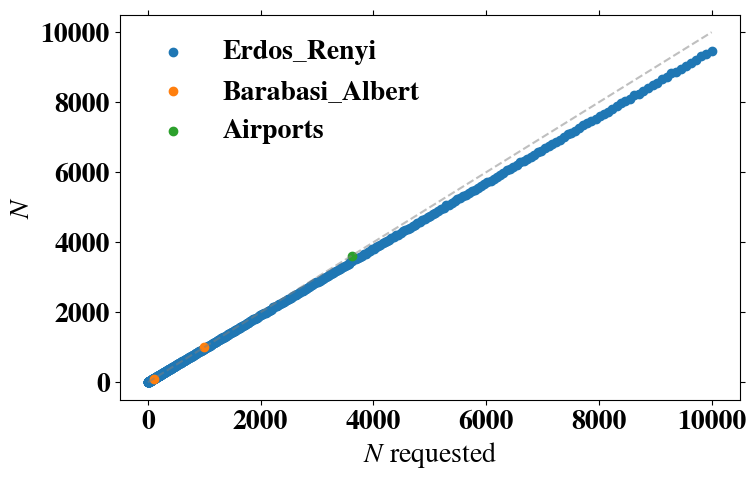

In [30]:
for name_graph in list(N_requested_to_real_dict.keys()):
    plt.scatter(list(N_requested_to_real_dict[name_graph].keys()),list(N_requested_to_real_dict[name_graph].values()),label=name_graph)
plt.plot([1,1e4],[1,1e4],ls="--",color="gray",alpha=0.5)
plt.legend()
plt.xlabel(r"$N$ requested")
plt.ylabel(r"$N$")

Text(0, 0.5, '$M$')

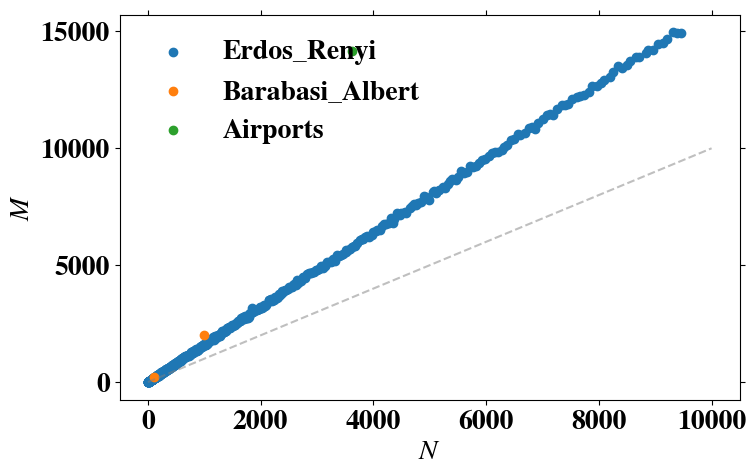

In [31]:
for name_graph in list(N_requested_to_real_dict.keys()):
    plt.scatter(list(N_requested_to_real_dict[name_graph].values()),list(N_requested_to_real_M_dict[name_graph].values()),label=name_graph)
plt.plot([1,1e4],[1,1e4],ls="--",color="gray",alpha=0.5)
plt.legend()
# plt.loglog()
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")

## Get data

In [32]:
dt = int(1e13)
algorithms = ["URW", "MERW","ARW",]
alpha = 0.1 # scaling parameter exponent for ARW

In [33]:
# This loads all the simulations with different N
results_fig3 = {}

for name_graph in ["Erdos_Renyi"]:
    results_fig3[name_graph] = {}
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        results_fig3[name_graph][algorithm] = {"N_list":[], "M_list":[], "covering_time":[]}
        found = 0
        covered = 0
        for N_requested,N in tqdm(N_requested_to_real_dict[name_graph].items()):
            avg_k = N_requested_to_real_M_dict[name_graph][N_requested] * 2 / N
            for ID in range(1000):
                try:
                    if algorithm == "ARW":
                        file_path = os.path.join(results_dir, "different_N", f"{name_graph}_{N_requested}", algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                    else:
                        file_path = os.path.join(results_dir, "different_N", f"{name_graph}_{N_requested}", algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                    with open(file_path, "rb") as fp:
                        tmp = joblib.load(fp)
                    found += 1
                    if tmp["covering_time_links"] != -1 and N not in results_fig3[name_graph][algorithm]["N_list"]:
                        results_fig3[name_graph][algorithm]["N_list"].append(N)
                        results_fig3[name_graph][algorithm]["M_list"].append(N_requested_to_real_M_dict[name_graph][N_requested])
                        results_fig3[name_graph][algorithm]["covering_time"].append(tmp["covering_time_links"])
                        covered += 1
                        break
                except FileNotFoundError:
                    pass
        print(f"\t\t FOUND: {found}, FINISHED: {covered}", flush=True)

Graph Erdos_Renyi, algorithm URW


  0%|          | 0/600 [00:00<?, ?it/s]

		 FOUND: 598, FINISHED: 565
Graph Erdos_Renyi, algorithm MERW


  0%|          | 0/600 [00:00<?, ?it/s]

		 FOUND: 563, FINISHED: 530
Graph Erdos_Renyi, algorithm ARW


  0%|          | 0/600 [00:00<?, ?it/s]

		 FOUND: 448, FINISHED: 415


## Plot

URW found 565
MERW found 530
ARW found 415


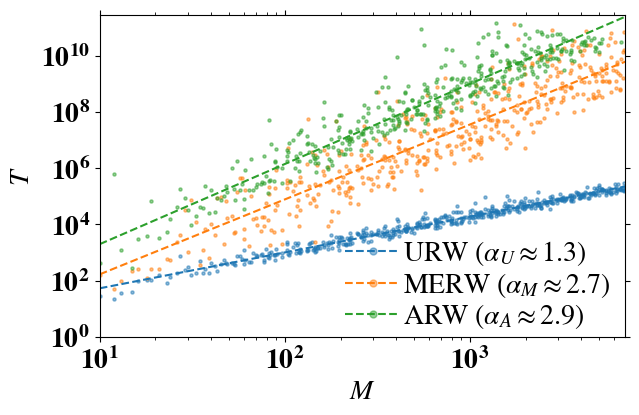

In [34]:
width = 8.6*cm*2
fig, ax = plt.subplots(1,1,figsize=(width,width/golden), gridspec_kw={'hspace':.3,'wspace':0.3})

labels = []
name_graph = "Erdos_Renyi"
N_or_M_list_keyword = "M"
alpha_scatter = 0.5
markersize = 5 # 10

algorithms_found = []
for column,algorithm in enumerate(algorithms):
    tmp = results_fig3[name_graph][algorithm]
    if len(tmp[N_or_M_list_keyword + "_list"]) > 0:
        algorithms_found.append(algorithm)
        slope, intercept, std_err = powerLawRegrPoints(tmp[N_or_M_list_keyword + "_list"], tmp["covering_time"])
        label = algorithm + r" ($\alpha_{%s} \approx %.1f$)"%(algorithm[0],slope,)
        ax.scatter(tmp[N_or_M_list_keyword + "_list"],tmp["covering_time"],s=markersize,label=label, alpha=alpha_scatter,color=colors[column])
        labels.append(label)
        t = np.array([max(10,0.9*min(tmp[N_or_M_list_keyword + "_list"])),1.05*max(tmp[N_or_M_list_keyword + "_list"])])
        ax.plot(t,t**slope * 10**intercept, alpha=1,color=colors[column], ls="--") 
    print(algorithm, "found", len(tmp[N_or_M_list_keyword + "_list"]))
        
    
ax.set_xscale("log")
ax.set_xlim(t)
ax.set_xlabel(r"$%s$"%(N_or_M_list_keyword))
ax.set_yscale("log")
ax.set_yticks([1e0,1e2,1e4,1e6,1e8,1e10,1e12,1e14])
ax.set_ylim(bottom=1,top=2*max([max(tmp["covering_time"]) for algorithm,tmp in results_fig3[name_graph].items() if algorithm in algorithms_found]))
ax.set_ylabel(r"$T$")

leg = ax.legend([plt.plot([],ls="--",marker="o",markersize=markersize, markerfacecolor=tuple(list(matplotlib.colors.to_rgb(colors[i]))+[alpha_scatter]), 
                color=colors[i])[0] for i in range(len(algorithms_found))],labels, handletextpad=0.1, scatterpoints=1,
                loc='lower right', bbox_to_anchor=(1.02, -0.06), 
                markerscale=1, edgecolor=(0.5, 0.5, 0.5, 1), facecolor=(1, 1, 1, alpha_scatter),
                labelspacing = 0.1, 
                prop={"weight":"normal","size":20},
               ) 

os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + f"figures/Fig3_covering_time_{N_or_M_list_keyword}.pdf",bbox_inches="tight")

# Figure SM 1

## Get data

In [35]:
# get the graphs to use in the plots
graphs = {}

N_requested = 1000

for name_graph in ["Erdos_Renyi","Barabasi_Albert","Airports"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    G, A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested,
        graph_dir = graph_dir, 
        max_tries = 1,
        show_graph = False, use_spring_layout=True, use_circular_layout=False, save_fig=False, save_as_pdf=True,
        do_prints = True, create_new = False)
    graphs[name_graph] = G.copy()

Loaded Erdos_Renyi with requested N=1000 and average degree avg_k=3.00, actual is N=962 and avg_k=3.19.
Loaded Barabasi_Albert with requested N=1000 and average degree avg_k=4.00, actual is N=1000 and avg_k=3.99.
Loaded Airports with actual N=3618 and avg_k=7.82.


In [36]:
algorithms = ["URW", "MERW", "ARW"]
entropy_type = 2 # entropy is calculated on the subgraph made by only the explored links
alpha = 0.1 # scaling parameter exponent for ARW

In [37]:
# SINGLE DATA for first row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
results_fig_SM1 = {}
for name_graph,G in graphs.items():
    results_fig_SM1[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in ["ARW", "MERW", "URW"]:
        print(f"Looking for {name_graph} {algorithm}")
        max_err = 0
        for ID in range(200): # this can be changed
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                if np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100]) > max_err: # this can be changed
                    max_err = np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100])
                    results_fig_SM1[name_graph][algorithm] = tmp
            except FileNotFoundError as e:
                pass

Looking for Erdos_Renyi ARW
Looking for Erdos_Renyi MERW
Looking for Erdos_Renyi URW
Looking for Barabasi_Albert ARW
Looking for Barabasi_Albert MERW
Looking for Barabasi_Albert URW
Looking for Airports ARW
Looking for Airports MERW
Looking for Airports URW


In [ ]:
# AVERAGE DATA for second row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
links_list_results_fig_SM1 = {}
mean_error_results_fig_SM1 = {}
std_error_results_fig_SM1 = {}
q1_error_results_fig_SM1 = {}
q2_error_results_fig_SM1 = {}
q3_error_results_fig_SM1 = {}
num_results_fig_SM1 = {}
finished_results_fig_SM1 = {}
for name_graph,G in graphs.items():
    links_list_results_fig_SM1[name_graph] = {}
    mean_error_results_fig_SM1[name_graph] = {}
    std_error_results_fig_SM1[name_graph] = {}
    q1_error_results_fig_SM1[name_graph] = {}
    q2_error_results_fig_SM1[name_graph] = {}
    q3_error_results_fig_SM1[name_graph] = {}
    num_results_fig_SM1[name_graph] = {}
    finished_results_fig_SM1[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    # Loading files
    for algorithm in ["ARW", "MERW", "URW"]:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        alpha = 0.1
        std_error_results_fig_SM1[name_graph][algorithm] = []
        num_results_fig_SM1[name_graph][algorithm] = 0
        finished_results_fig_SM1[name_graph][algorithm] = 0
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                links_list_results_fig_SM1[name_graph][algorithm] = tmp["M_list"]
                num_results_fig_SM1[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_results_fig_SM1[name_graph][algorithm] += 1
                # we append the array of all errors into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_error_results_fig_SM1[name_graph][algorithm].append([(tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] - tmp["empirical_entr_prod_list_M"][entropy_type][i])/tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] if tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] != 0 else 0 for i in range(len(tmp["maximum_entr_prod_explored_list_M"][entropy_type]))])
            except FileNotFoundError as e:
                pass
        
        # Calculation of all variables
        mean_error_results_fig_SM1[name_graph][algorithm] = []
        q1_error_results_fig_SM1[name_graph][algorithm] = []
        q2_error_results_fig_SM1[name_graph][algorithm] = []
        q3_error_results_fig_SM1[name_graph][algorithm] = []
        tmp_std = []
        for i in range(len(links_list_results_fig_SM1[name_graph][algorithm])):
            mean_error_results_fig_SM1[name_graph][algorithm].append(np.mean(np.array([std_error_results_fig_SM1[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM1[name_graph][algorithm])) if std_error_results_fig_SM1[name_graph][algorithm][ID][i] != -1]))) 
            q1_error_results_fig_SM1[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM1[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM1[name_graph][algorithm])) if std_error_results_fig_SM1[name_graph][algorithm][ID][i] != -1]),25)) 
            q2_error_results_fig_SM1[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM1[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM1[name_graph][algorithm])) if std_error_results_fig_SM1[name_graph][algorithm][ID][i] != -1]),50)) 
            q3_error_results_fig_SM1[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM1[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM1[name_graph][algorithm])) if std_error_results_fig_SM1[name_graph][algorithm][ID][i] != -1]),75)) 
            tmp_std.append(np.std(np.array([std_error_results_fig_SM1[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM1[name_graph][algorithm])) if std_error_results_fig_SM1[name_graph][algorithm][ID][i] != -1])))
            
        mean_error_results_fig_SM1[name_graph][algorithm] = np.array(mean_error_results_fig_SM1[name_graph][algorithm])
        q1_error_results_fig_SM1[name_graph][algorithm] = np.array(q1_error_results_fig_SM1[name_graph][algorithm])
        q2_error_results_fig_SM1[name_graph][algorithm] = np.array(q2_error_results_fig_SM1[name_graph][algorithm])
        q3_error_results_fig_SM1[name_graph][algorithm] = np.array(q3_error_results_fig_SM1[name_graph][algorithm])
        std_error_results_fig_SM1[name_graph][algorithm] = np.array(tmp_std)
        print(f"\t\t FOUND: {num_results_fig_SM1[name_graph][algorithm]}, FINISHED: {finished_results_fig_SM1[name_graph][algorithm]}", flush=True)

Graph Erdos_Renyi, algorithm ARW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 870
Graph Erdos_Renyi, algorithm MERW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Erdos_Renyi, algorithm URW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Barabasi_Albert, algorithm ARW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 742
Graph Barabasi_Albert, algorithm MERW


  0%|          | 0/1000 [00:00<?, ?it/s]

		 FOUND: 1000, FINISHED: 1000
Graph Barabasi_Albert, algorithm URW


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Calculation of max_M based on the max number of links explored in the ARW
max_M = {}
for column,name_graph in enumerate(results_fig_SM1.keys()):
    for algorithm in ["ARW"]:
        if algorithm in results_fig_SM1[name_graph]:
            q1 = q1_error_results_fig_SM1[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            links_list = links_list_results_fig_SM1[name_graph][algorithm][indices]
            max_M[name_graph] = links_list[-1]

## Plot

In [ ]:
width = 8.6*cm*2
width_fig = width * 2.37
height_fig = width_fig/golden*2/3
num_columns = len(results_fig2.keys())
fig, axes = plt.subplots(2,num_columns,figsize=(width_fig,height_fig), gridspec_kw={'hspace':.12,'wspace':0.13})
counter = -1

############################# FIRST ROW #############################
row = 0 # SINGLE DATA
for column,name_graph in enumerate(results_fig_SM1.keys()):
    counter += 1
    ax = axes[row,column]
    
    for color_id,algorithm in enumerate(["URW", "MERW", "ARW"]):
        if algorithm in results_fig_SM1[name_graph]:
            tmp = results_fig_SM1[name_graph][algorithm]
            try:
                last_index = list(tmp["maximum_entr_prod_explored_list_M"][entropy_type]).index(-1)
            except ValueError:
                last_index = len(tmp["maximum_entr_prod_explored_list_M"][entropy_type])
            ax.plot(tmp["M_list"][:last_index],tmp["empirical_entr_prod_list_M"][entropy_type][:last_index],label=algorithm, alpha=1,color=colors[color_id])
            ax.plot(tmp["M_list"][:last_index],tmp["maximum_entr_prod_explored_list_M"][entropy_type][:last_index],"--", alpha=1,color=colors[color_id])

    expected_entr_prod = tmp["maximum_entr_prod"]
    ax.axhline(expected_entr_prod, ls="--", color="gray", label="max",alpha=0.5)
    
    ax.set_xscale("log")
    left = 1
    right = max_M[name_graph]
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_xlim(left=left,right=right)
    
    ax.set_ylim([-0.02,expected_entr_prod*1.15])

    if column == 0:
        leg = ax.legend([(colors[i],"--",True) for i in range(len(algorithms))] + [((0.5,0.5,0.5,0.5),"--",False)], algorithms + [r"$h_1$"], 
                       handler_map={tuple: continuous_and_dashed_line_handle()},
                       prop={'weight':'normal'},
                       handletextpad=0.3, 
                       loc='lower right', bbox_to_anchor=(1.02, -0.08), markerscale=1,
                       frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                       labelspacing = 0.,
                       ) 
        ax.set_ylabel(r"$h$")

    ax.tick_params(labelleft = True , labelbottom = False)
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
        
############################# SECOND ROW #############################
row = 1 # AVERAGE DATA
for column,name_graph in enumerate(results_fig_SM1.keys()):
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(["URW", "MERW", "ARW"]):
        if algorithm in results_fig_SM1[name_graph]:
            q1 = q1_error_results_fig_SM1[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            almost_0 = 0
            links_list = links_list_results_fig_SM1[name_graph][algorithm] 
            mean_list = np.array([mean_error_results_fig_SM1[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            std_list = np.array([std_error_results_fig_SM1[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q1 = np.array([q1_error_results_fig_SM1[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q2 = np.array([q2_error_results_fig_SM1[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q3 = np.array([q3_error_results_fig_SM1[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            ax.plot(links_list,q2,label=algorithm, alpha=1,color=colors[color_id])
            ax.fill_between(links_list, q1, q3, color=colors[color_id], alpha = 0.2,lw=0)
    
    ax.axhline(0, ls="--", color="gray")
    
    ax.set_xscale("log")
    ax.set_xlabel(r"$M$")
    left = 1
    right = max_M[name_graph] 
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_yscale("log")
    ax.set_ylim(top = 2, bottom = 1e-7)

    if column == 0:
        leg = ax.legend([(colors[i],matplotlib.colors.to_rgba(colors[i], 0.2)) for i in range(len(algorithms))], algorithms,
                               handler_map={tuple: line_and_filled_handle()},
                        handletextpad=0.3, 
                               loc='lower right', bbox_to_anchor=(1.02, -0.05), markerscale=1,
                        prop={'weight':'normal'},
                        frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                        labelspacing = 0.2,
                        ) 
        ax.set_ylabel(r"$\langle (\bar{h} - h) \; / \; \bar{h}\rangle_{\mathrm{Me}}$")
    else:
        ax.tick_params(labelleft = False , labelbottom = True)

    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + "figures/FigSM_1_entropy_nodes_explored.pdf",bbox_inches="tight")

# Figure SM 2

## Get data

In [ ]:
# get the graphs to use in the plots
graphs = {}

N_requested = 1000

for name_graph in ["Erdos_Renyi","Barabasi_Albert","Airports"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    G, A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested,
        graph_dir = graph_dir, 
        max_tries = 1,
        show_graph = False, use_spring_layout=True, use_circular_layout=False, save_fig=False, save_as_pdf=True,
        do_prints = True, create_new = False)
    graphs[name_graph] = G.copy()

In [ ]:
algorithms = ["URW", "MERW", "ARW"]
alpha = 0.1 # scaling parameter exponent for ARW

In [ ]:
# SINGLE DATA for first row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
results_fig_SM2 = {}
for name_graph,G in graphs.items():
    results_fig_SM2[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in algorithms:
        print(f"Looking for {name_graph} {algorithm}")
        max_err = 0
        for ID in range(200): # this can be changed
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                if np.median(tmp["maximum_entr_prod_explored_list_M"][3][20:100] - tmp["empirical_entr_prod_list_M"][3][20:100]) > max_err: # this can be changed
                    max_err = np.median(tmp["maximum_entr_prod_explored_list_M"][3][20:100] - tmp["empirical_entr_prod_list_M"][3][20:100])
                    results_fig_SM2[name_graph][algorithm] = tmp
            except FileNotFoundError as e:
                pass

In [ ]:
# AVERAGE DATA for second row
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
links_list_results_fig_SM2 = {}
mean_results_fig_SM2 = {}
std_results_fig_SM2 = {}
q1_results_fig_SM2 = {}
q2_results_fig_SM2 = {}
q3_results_fig_SM2 = {}
num_results_fig_SM2 = {}
finished_results_fig_SM2 = {}
for name_graph,G in graphs.items():
    links_list_results_fig_SM2[name_graph] = {}
    mean_results_fig_SM2[name_graph] = {}
    std_results_fig_SM2[name_graph] = {}
    q1_results_fig_SM2[name_graph] = {}
    q2_results_fig_SM2[name_graph] = {}
    q3_results_fig_SM2[name_graph] = {}
    num_results_fig_SM2[name_graph] = {}
    finished_results_fig_SM2[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in ["ARW", "MERW", "URW"]:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        alpha = 0.1
        std_results_fig_SM2[name_graph][algorithm] = []
        num_results_fig_SM2[name_graph][algorithm] = 0
        finished_results_fig_SM2[name_graph][algorithm] = 0
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                links_list_results_fig_SM2[name_graph][algorithm] = np.array(list(range(len(tmp["time_explored_links_list_M"])))) + 1 # tmp["M_list"]
                num_results_fig_SM2[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_results_fig_SM2[name_graph][algorithm] += 1
                # we append the array of all times into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_results_fig_SM2[name_graph][algorithm].append([tmp["time_explored_links_list_M"][i] for i in range(len(tmp["time_explored_links_list_M"]))])
            except FileNotFoundError as e:
                pass
        
        # Calculation of all variables
        mean_results_fig_SM2[name_graph][algorithm] = []
        q1_results_fig_SM2[name_graph][algorithm] = []
        q2_results_fig_SM2[name_graph][algorithm] = []
        q3_results_fig_SM2[name_graph][algorithm] = []
        tmp_std = []
        for i in range(len(links_list_results_fig_SM2[name_graph][algorithm])):
            if len([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1]) > 0:
                mean_results_fig_SM2[name_graph][algorithm].append(np.mean(np.array([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1]))) 
                q1_results_fig_SM2[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1]),25)) 
                q2_results_fig_SM2[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1]),50)) 
                q3_results_fig_SM2[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1]),75)) 
                tmp_std.append(np.std(np.array([std_results_fig_SM2[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM2[name_graph][algorithm])) if std_results_fig_SM2[name_graph][algorithm][ID][i] != -1])))
            
        mean_results_fig_SM2[name_graph][algorithm] = np.array(mean_results_fig_SM2[name_graph][algorithm])
        q1_results_fig_SM2[name_graph][algorithm] = np.array(q1_results_fig_SM2[name_graph][algorithm])
        q2_results_fig_SM2[name_graph][algorithm] = np.array(q2_results_fig_SM2[name_graph][algorithm])
        q3_results_fig_SM2[name_graph][algorithm] = np.array(q3_results_fig_SM2[name_graph][algorithm])
        std_results_fig_SM2[name_graph][algorithm] = np.array(tmp_std)
        print(f"\t\t FOUND: {num_results_fig_SM2[name_graph][algorithm]}, FINISHED: {finished_results_fig_SM2[name_graph][algorithm]}", flush=True)

In [ ]:
# Calculation of max_M based on the max number of links explored in the ARW
max_M = {}
for column,name_graph in enumerate(results_fig_SM2.keys()):
    for algorithm in ["ARW"]:
        if algorithm in results_fig_SM2[name_graph]:
            q1 = q1_results_fig_SM2[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            links_list = links_list_results_fig_SM2[name_graph][algorithm][indices] # np.array(list(range(len(indices))))+1
            max_M[name_graph] = links_list[-1]

## Plot

In [ ]:
width = 8.6*cm*2
width_fig = width * 2.37
height_fig = width_fig/golden*2/3
num_columns = len(results_fig2.keys())
fig, axes = plt.subplots(2,num_columns,figsize=(width_fig,height_fig), gridspec_kw={'hspace':.12,'wspace':0.13})
counter = -1

############################# FIRST ROW #############################
row = 0 # SINGLE DATA
for column,name_graph in enumerate(results_fig_SM2.keys()):
    counter += 1
    ax = axes[row,column]
    
    for color_id,algorithm in enumerate(["URW", "MERW", "ARW"]):
        if algorithm in results_fig_SM2[name_graph]:
            tmp = results_fig_SM2[name_graph][algorithm]
            try:
                last_index = list(tmp["time_explored_links_list_M"]).index(-1)
            except ValueError:
                last_index = len(tmp["time_explored_links_list_M"])
            ax.plot(np.array(list(range(tmp["M"])))[:last_index]+1,tmp["time_explored_links_list_M"][:last_index],label=algorithm, alpha=1,color=colors[color_id])

    ax.set_xscale("log")
    left = 1
    right = max_M[name_graph] 
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_yscale("log")
    bottom = 1
    top = 1e10
    ax.set_ylim(bottom=bottom, top = top)
    ax.set_yticks(np.geomspace(bottom,10**int(np.log10(top)),num=int((int(np.log10(top)-np.log10(bottom))/2)+1)))
    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    ax.xaxis.set_minor_locator(locminX)

    if column == 0:
        leg = ax.legend(prop={'weight':'normal'},
                        handletextpad=0.3, 
                        loc='upper left', bbox_to_anchor=(.0, 1), markerscale=1, 
                        frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                        labelspacing = 0.4,
                        ) 
        ax.set_ylabel(r"$T$")
        ax.tick_params(labelleft = True , labelbottom = False)
    else:
        ax.tick_params(labelleft = False , labelbottom = False)
    
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
    
############################# SECOND ROW #############################
row = 1 # AVERAGE DATA
for column,name_graph in enumerate(results_fig_SM2.keys()):
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(["URW", "MERW", "ARW"]):
        if algorithm in results_fig_SM2[name_graph]:
            q1 = q1_results_fig_SM2[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            almost_0 = 0
            links_list = np.array(list(range(len(indices))))+1 
            mean_list = np.array([mean_results_fig_SM2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            std_list = np.array([std_results_fig_SM2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q1 = np.array([q1_results_fig_SM2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q2 = np.array([q2_results_fig_SM2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q3 = np.array([q3_results_fig_SM2[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            ax.plot(links_list,q2,label=algorithm, alpha=1,color=colors[color_id])
            ax.fill_between(links_list, q1, q3, color=colors[color_id], alpha = 0.2,lw=0)
    
    ax.axhline(0, ls="--", color="gray")
    
    ax.set_xscale("log")
    ax.set_xlabel(r"$M$")
    left = 1
    right = max_M[name_graph] 
    ax.set_xlim(left=left,right=right)
    ax.set_xscale("log")
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_ylim(bottom = 1, top = 1e10)
    ax.set_yscale("log")
    ax.set_yticks(np.geomspace(1,10**int(np.log10(top)),num=int((int(np.log10(top)-np.log10(1))/2)+1)))
    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    ax.xaxis.set_minor_locator(locminX)
    
    if column == 0:
        leg = ax.legend([(colors[i],matplotlib.colors.to_rgba(colors[i], 0.2)) for i in range(len(algorithms))], algorithms,
                        handler_map={tuple: line_and_filled_handle()},
                        handletextpad=0.3, 
                        loc='upper left', bbox_to_anchor=(.0, 1), markerscale=1,
                        prop={'weight':'normal'},
                        frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                        labelspacing = 0.4,
                        ) 
        ax.set_ylabel(r"$\langle T \rangle_{\mathrm{Me}}$")
    else:
        ax.tick_params(labelleft = False , labelbottom = True)
        
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + "figures/FigSM_2_time_exploration_links.pdf",bbox_inches="tight")

# Figure SM 3

## Get data

In [ ]:
# get the graphs to use in the plots
graphs = {}

N_requested = 100

for name_graph in ["Erdos_Renyi"]: #,"Barabasi_Albert","Airports"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    G, A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested,
        graph_dir = graph_dir, 
        max_tries = 1,
        show_graph = False, use_spring_layout=True, use_circular_layout=False, save_fig=False, save_as_pdf=True,
        do_prints = True, create_new = False)
    graphs[name_graph] = G.copy()

In [ ]:
ARW_no_norm = r"$\overline{\mathrm{ARW}}$" # r"ARW$_{no\,norm.}$" # "ARW (no norm.)"
algorithms = ["URW", "MERW","ARW", ARW_no_norm,]
entropy_type = 3 # entropy is calculated on the subgraph made by only the explored links
alpha = 0.1 # scaling parameter exponent for ARW

### A

M vs time exploration of links

In [ ]:
# AVERAGE DATA
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
links_list_results_fig_SM3_A = {}
mean_results_fig_SM3_A = {}
std_results_fig_SM3_A = {}
q1_results_fig_SM3_A = {}
q2_results_fig_SM3_A = {}
q3_results_fig_SM3_A = {}
num_results_fig_SM3_A = {}
finished_results_fig_SM3_A = {}
for name_graph,G in graphs.items():
    links_list_results_fig_SM3_A[name_graph] = {}
    mean_results_fig_SM3_A[name_graph] = {}
    std_results_fig_SM3_A[name_graph] = {}
    q1_results_fig_SM3_A[name_graph] = {}
    q2_results_fig_SM3_A[name_graph] = {}
    q3_results_fig_SM3_A[name_graph] = {}
    num_results_fig_SM3_A[name_graph] = {}
    finished_results_fig_SM3_A[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        std_results_fig_SM3_A[name_graph][algorithm] = []
        num_results_fig_SM3_A[name_graph][algorithm] = 0
        finished_results_fig_SM3_A[name_graph][algorithm] = 0
        # Loading files
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                elif algorithm == ARW_no_norm:
                    file_path = os.path.join(results_dir, "no_renormalization_no_stop", name_graph, "ARW", f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                links_list_results_fig_SM3_A[name_graph][algorithm] = np.array(list(range(len(tmp["time_explored_links_list_M"])))) + 1 # tmp["M_list"]
                num_results_fig_SM3_A[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_results_fig_SM3_A[name_graph][algorithm] += 1
                # we append the array of all times into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_results_fig_SM3_A[name_graph][algorithm].append([tmp["time_explored_links_list_M"][i] for i in range(len(tmp["time_explored_links_list_M"]))])
            except FileNotFoundError as e:
                pass
        
        # Calculation of all variables
        mean_results_fig_SM3_A[name_graph][algorithm] = []
        q1_results_fig_SM3_A[name_graph][algorithm] = []
        q2_results_fig_SM3_A[name_graph][algorithm] = []
        q3_results_fig_SM3_A[name_graph][algorithm] = []
        tmp_std = []
        for i in range(len(links_list_results_fig_SM3_A[name_graph][algorithm])):
            if len([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1]) > 0:
                mean_results_fig_SM3_A[name_graph][algorithm].append(np.mean(np.array([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1]))) 
                q1_results_fig_SM3_A[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1]),25)) 
                q2_results_fig_SM3_A[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1]),50)) 
                q3_results_fig_SM3_A[name_graph][algorithm].append(np.percentile(np.array([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1]),75)) 
                tmp_std.append(np.std(np.array([std_results_fig_SM3_A[name_graph][algorithm][ID][i] for ID in range(len(std_results_fig_SM3_A[name_graph][algorithm])) if std_results_fig_SM3_A[name_graph][algorithm][ID][i] != -1])))
            
        mean_results_fig_SM3_A[name_graph][algorithm] = np.array(mean_results_fig_SM3_A[name_graph][algorithm])
        q1_results_fig_SM3_A[name_graph][algorithm] = np.array(q1_results_fig_SM3_A[name_graph][algorithm])
        q2_results_fig_SM3_A[name_graph][algorithm] = np.array(q2_results_fig_SM3_A[name_graph][algorithm])
        q3_results_fig_SM3_A[name_graph][algorithm] = np.array(q3_results_fig_SM3_A[name_graph][algorithm])
        std_results_fig_SM3_A[name_graph][algorithm] = np.array(tmp_std)
        print(f"\t\t FOUND: {num_results_fig_SM3_A[name_graph][algorithm]}, FINISHED: {finished_results_fig_SM3_A[name_graph][algorithm]}", flush=True)

In [ ]:
# Calculation of max_M_A based on the max number of links explored in the ARW
max_M_A = {}
for column,name_graph in enumerate(graphs.keys()):
    for algorithm in ["ARW"]:
        if algorithm in q1_results_fig_SM3_A[name_graph]:
            q1 = q1_results_fig_SM3_A[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            links_list = links_list_results_fig_SM3_A[name_graph][algorithm][indices] 
            max_M_A[name_graph] = links_list[-1]

### B

M vs covering time

In [ ]:
N_requested_to_real_dict = {} # key: name_graph, value: dict(key: N_requested, value: N of LCC)
N_requested_to_real_M_dict = {} # key: name_graph, value: dict(key: N_requested, value: M of LCC)

for name_graph in ["Erdos_Renyi","Barabasi_Albert"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    N_requested_to_real_dict[name_graph] = {}
    N_requested_to_real_M_dict[name_graph] = {}
    
    N_list = [100,1000]
    
    for N_requested in tqdm(N_list):
        G,A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested, 
            graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
        N_requested_to_real_dict[name_graph][N_requested] = len(G)
        N_requested_to_real_M_dict[name_graph][N_requested] = len(G.edges())
        

name_graph = "Airports"
G,A = load_graph(name_graph = name_graph, N_requested = 1, avg_k_requested = 1, 
    graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
N_requested = len(G)
N_requested_to_real_dict[name_graph] = {N_requested: len(G)}
N_requested_to_real_M_dict[name_graph] = {N_requested: len(G.edges())}

        
        
for name_graph in ["Erdos_Renyi"]:
    if name_graph == "Erdos_Renyi":
        avg_k_requested = 3.
    elif name_graph == "Barabasi_Albert":
        avg_k_requested = 4.
        
    N_list = sorted(set(list(np.geomspace(1, 10000, 1000, dtype=np.int64))))
    
    for N_requested in tqdm(N_list):
        G,A = load_graph(name_graph = name_graph, N_requested = N_requested, avg_k_requested = avg_k_requested, 
            graph_dir = graph_dir, max_tries=1, do_prints = False, create_new = False,)
        N_requested_to_real_dict[name_graph][N_requested] = len(G)
        N_requested_to_real_M_dict[name_graph][N_requested] = len(G.edges())

In [ ]:
# This loads all the simulations with different N
dt = int(1e13)
results_fig_SM3_B = {}

for name_graph in ["Erdos_Renyi"]:
    results_fig_SM3_B[name_graph] = {}
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        results_fig_SM3_B[name_graph][algorithm] = {"N_list":[], "M_list":[], "covering_time":[]}
        found = 0
        covered = 0
        for N_requested,N in tqdm(N_requested_to_real_dict[name_graph].items()):
            avg_k = N_requested_to_real_M_dict[name_graph][N_requested] * 2 / N
            for ID in range(1000):
                try:
                    if algorithm == "ARW":
                        file_path = os.path.join(results_dir, "different_N", f"{name_graph}_{N_requested}", algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                    elif algorithm == ARW_no_norm:
                        file_path = os.path.join(results_dir, "different_N_no_renormalization", f"{name_graph}_{N_requested}", "ARW", f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                    else:
                        file_path = os.path.join(results_dir, "different_N", f"{name_graph}_{N_requested}", algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                    with open(file_path, "rb") as fp:
                        tmp = joblib.load(fp)
                    found += 1
                    if tmp["covering_time_links"] != -1 and N not in results_fig_SM3_B[name_graph][algorithm]["N_list"]:
                        results_fig_SM3_B[name_graph][algorithm]["N_list"].append(N)
                        results_fig_SM3_B[name_graph][algorithm]["M_list"].append(N_requested_to_real_M_dict[name_graph][N_requested])
                        results_fig_SM3_B[name_graph][algorithm]["covering_time"].append(tmp["covering_time_links"])
                        covered += 1
                        break
                except FileNotFoundError:
                    pass
        print(f"\t\t FOUND: {found}, FINISHED: {covered}", flush=True)

### C

M vs $h$

In [ ]:
# SINGLE DATA
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
results_fig_SM3_C = {}
for name_graph,G in graphs.items():
    results_fig_SM3_C[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in algorithms:
        print(f"Looking for {name_graph} {algorithm}")
        max_err = 0
        min_err = 10000
        for ID in range(200): # this can be changed
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                elif algorithm == ARW_no_norm:
                    file_path = os.path.join(results_dir, "no_renormalization_no_stop", name_graph, "ARW", f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                if "ARW" in algorithm and np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100]) < min_err: # this can be changed
                    min_err = np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100])
                    results_fig_SM3_C[name_graph][algorithm] = tmp
                elif "ARW" not in algorithm and np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100]) > max_err: # this can be changed
                    max_err = np.median(tmp["maximum_entr_prod_explored_list_M"][entropy_type][20:100] - tmp["empirical_entr_prod_list_M"][entropy_type][20:100])
                    results_fig_SM3_C[name_graph][algorithm] = tmp
            except FileNotFoundError as e:
                pass

### D

M vs $(\bar{h}-h) / \bar{h}$

In [ ]:
# AVERAGE DATA
dt = int(1e10) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]
links_list_results_fig_SM3_D = {}
mean_error_results_fig_SM3_D = {}
std_error_results_fig_SM3_D = {}
q1_error_results_fig_SM3_D = {}
q2_error_results_fig_SM3_D = {}
q3_error_results_fig_SM3_D = {}
num_results_fig_SM3_D = {}
finished_results_fig_SM3_D = {}
for name_graph,G in graphs.items():
    links_list_results_fig_SM3_D[name_graph] = {}
    mean_error_results_fig_SM3_D[name_graph] = {}
    std_error_results_fig_SM3_D[name_graph] = {}
    q1_error_results_fig_SM3_D[name_graph] = {}
    q2_error_results_fig_SM3_D[name_graph] = {}
    q3_error_results_fig_SM3_D[name_graph] = {}
    num_results_fig_SM3_D[name_graph] = {}
    finished_results_fig_SM3_D[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        std_error_results_fig_SM3_D[name_graph][algorithm] = []
        num_results_fig_SM3_D[name_graph][algorithm] = 0
        finished_results_fig_SM3_D[name_graph][algorithm] = 0
        # Loading files
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                elif algorithm == ARW_no_norm:
                    file_path = os.path.join(results_dir, "no_renormalization_no_stop", name_graph, "ARW", f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                links_list_results_fig_SM3_D[name_graph][algorithm] = tmp["M_list"]
                num_results_fig_SM3_D[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_results_fig_SM3_D[name_graph][algorithm] += 1
                # we append the array of all errors into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_error_results_fig_SM3_D[name_graph][algorithm].append([(tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] - tmp["empirical_entr_prod_list_M"][entropy_type][i])/tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] if tmp["maximum_entr_prod_explored_list_M"][entropy_type][i] != 0 else 0 for i in range(len(tmp["maximum_entr_prod_explored_list_M"][entropy_type]))])
            except FileNotFoundError as e:
                pass
        
        # Calculation of all variables
        mean_error_results_fig_SM3_D[name_graph][algorithm] = []
        q1_error_results_fig_SM3_D[name_graph][algorithm] = []
        q2_error_results_fig_SM3_D[name_graph][algorithm] = []
        q3_error_results_fig_SM3_D[name_graph][algorithm] = []
        tmp_std = []
        for i in range(len(links_list_results_fig_SM3_D[name_graph][algorithm])):
            mean_error_results_fig_SM3_D[name_graph][algorithm].append(np.mean(np.array([std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM3_D[name_graph][algorithm])) if std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] != -1]))) 
            q1_error_results_fig_SM3_D[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM3_D[name_graph][algorithm])) if std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] != -1]),25)) 
            q2_error_results_fig_SM3_D[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM3_D[name_graph][algorithm])) if std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] != -1]),50)) 
            q3_error_results_fig_SM3_D[name_graph][algorithm].append(np.percentile(np.array([std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM3_D[name_graph][algorithm])) if std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] != -1]),75)) 
            tmp_std.append(np.std(np.array([std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] for ID in range(len(std_error_results_fig_SM3_D[name_graph][algorithm])) if std_error_results_fig_SM3_D[name_graph][algorithm][ID][i] != -1])))
            
        mean_error_results_fig_SM3_D[name_graph][algorithm] = np.array(mean_error_results_fig_SM3_D[name_graph][algorithm])
        q1_error_results_fig_SM3_D[name_graph][algorithm] = np.array(q1_error_results_fig_SM3_D[name_graph][algorithm])
        q2_error_results_fig_SM3_D[name_graph][algorithm] = np.array(q2_error_results_fig_SM3_D[name_graph][algorithm])
        q3_error_results_fig_SM3_D[name_graph][algorithm] = np.array(q3_error_results_fig_SM3_D[name_graph][algorithm])
        std_error_results_fig_SM3_D[name_graph][algorithm] = np.array(tmp_std)
        print(f"\t\t FOUND: {num_results_fig_SM3_D[name_graph][algorithm]}, FINISHED: {finished_results_fig_SM3_D[name_graph][algorithm]}", flush=True)

In [ ]:
# Calculation of max_M_D based on the max number of links explored in the ARW
max_M_D = {}

for column,name_graph in enumerate(graphs.keys()):
    for algorithm in ["ARW"]:
        if algorithm in q1_error_results_fig_SM3_D[name_graph]:
            q1 = q1_error_results_fig_SM3_D[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            links_list = links_list_results_fig_SM3_D[name_graph][algorithm][indices]
            max_M_D[name_graph] = links_list[-1]

## Plot

In [ ]:
width = 8.6*cm*2
num_rows = 2
num_columns = 2
fig, axes = plt.subplots(num_rows,num_columns,figsize=(width*num_columns,width/golden*num_rows), gridspec_kw={'hspace':.17,'wspace':0.27})
counter = -1


################################## A ##################################
# A: M vs time exploration links
row = 0 
column = 0
    
for name_graph in graphs.keys():
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(algorithms):
        if algorithm in q1_results_fig_SM3_A[name_graph]:
            q1 = q1_results_fig_SM3_A[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            almost_0 = 0
            links_list = np.array(list(range(len(indices))))+1 
            mean_list = np.array([mean_results_fig_SM3_A[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            std_list = np.array([std_results_fig_SM3_A[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q1 = np.array([q1_results_fig_SM3_A[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q2 = np.array([q2_results_fig_SM3_A[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q3 = np.array([q3_results_fig_SM3_A[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            ax.plot(links_list,q2,label=algorithm, alpha=1,color=colors[color_id])
            ax.fill_between(links_list, q1, q3, color=colors[color_id], alpha = 0.2,lw=0)
    
    ax.axhline(0, ls="--", color="gray")
    
    left = 1
    right = max_M_A[name_graph] 
    ax.set_xlim(left=left,right=right)
    ax.set_xscale("log")
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    top = 1e7
    ax.set_yticks(np.geomspace(1,10**int(np.log10(top)),num=int((int(np.log10(top)-np.log10(1))/2)+1)))
    ax.set_ylim(bottom = 1, top = top)
    ax.set_yscale("log")
    ax.set_ylabel(r"$\langle T \rangle_\mathrm{Me}$")
    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    ax.xaxis.set_minor_locator(locminX)
    
    leg = ax.legend([(colors[i],matplotlib.colors.to_rgba(colors[i], 0.2)) for i in range(len(algorithms))], algorithms,
                    handler_map={tuple: line_and_filled_handle()},
                    handletextpad=0.3, 
                    loc='upper left', bbox_to_anchor=(-.02, 1.04), markerscale=1, 
                    prop={'weight':'normal'},
                    frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                    labelspacing = 0.4,
                    ) 
    
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
    
################################## B ##################################    
# B: M vs covering time
name_graph = "Erdos_Renyi"
row = 0
column = 1
counter += 1
ax = axes[row,column]
    
N_or_M_list_keyword = "M"
alpha_scatter = 0.5
markersize = 5 # 10

algorithms_found = []
labels = []
for column,algorithm in enumerate(algorithms):
    tmp = results_fig_SM3_B[name_graph][algorithm]
    if len(tmp[N_or_M_list_keyword + "_list"]) > 0:
        algorithms_found.append(algorithm)
        ax.scatter(tmp[N_or_M_list_keyword + "_list"],tmp["covering_time"],s=markersize,label=label, alpha=alpha_scatter,color=colors[column])
        slope, intercept, std_err = powerLawRegrPoints(tmp[N_or_M_list_keyword + "_list"], tmp["covering_time"])
        if algorithm == ARW_no_norm:
            label = algorithm + r" ($\alpha_{%s} \approx %.1f$)"%("AN",slope,)
        else:
            label = algorithm + r" ($\alpha_{%s} \approx %.1f$)"%(algorithm[0],slope,)
        labels.append(label)
        if algorithm == "ARW":
            t = np.array([max(10,0.9*min(tmp[N_or_M_list_keyword + "_list"])),1.05*max(tmp[N_or_M_list_keyword + "_list"])])
        ax.plot(t,t**slope * 10**intercept, alpha=1,color=colors[column], ls="--") 
    print(algorithm, "found", len(tmp[N_or_M_list_keyword + "_list"]))
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(t)
ax.set_yticks([1e0,1e2,1e4,1e6,1e8,1e10,1e12,1e14])
ax.set_ylim(bottom=1,top=14*max([max(tmp["covering_time"]) for algorithm,tmp in results_fig_SM3_B[name_graph].items() if algorithm in algorithms_found]))
ax.set_ylabel(r"$T$")

leg1 = ax.legend([plt.plot([],ls="--",marker="o",markersize=markersize,markerfacecolor=tuple(list(matplotlib.colors.to_rgb(colors[i]))+[alpha_scatter]), 
                color=colors[i])[0] for i in range(len(algorithms_found))][:2], labels[:2] , 
                handletextpad=0.1, scatterpoints=1,
                loc='upper left', bbox_to_anchor=(-.02, 1.04), 
                markerscale=1, edgecolor=(0.5, 0.5, 0.5, 1), facecolor=(1, 1, 1, alpha_scatter),
                labelspacing = 0.2, 
                prop={"weight":"normal","size":20},
               ) 
    
leg2 = ax.legend([plt.plot([],ls="--",marker="o",markersize=markersize,markerfacecolor=tuple(list(matplotlib.colors.to_rgb(colors[i]))+[alpha_scatter]), 
                color=colors[i])[0] for i in range(len(algorithms_found))][2:4], labels[2:4] ,
                handletextpad=0.1, scatterpoints=1,
                loc='lower right', bbox_to_anchor=(1.02, -0.05), 
                markerscale=1, edgecolor=(0.5, 0.5, 0.5, 1), facecolor=(1, 1, 1, alpha_scatter),
                labelspacing = 0.2,
                prop={"weight":"normal","size":20},
               ) 
    
ax.add_artist(leg1)
ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    

################################## C ##################################
# C: M vs h
row = 1
column = 0
for name_graph in results_fig_SM3_C.keys():
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(algorithms):
        if algorithm in results_fig_SM3_C[name_graph]:
            tmp = results_fig_SM3_C[name_graph][algorithm]
            try:
                last_index = list(tmp["maximum_entr_prod_explored_list_M"][3]).index(-1)
            except ValueError:
                last_index = len(tmp["maximum_entr_prod_explored_list_M"][3])
            ax.plot(tmp["M_list"][:last_index],tmp["empirical_entr_prod_list_M"][3][:last_index],label=algorithm, alpha=1,color=colors[color_id])
            ax.plot(tmp["M_list"][:last_index],tmp["maximum_entr_prod_explored_list_M"][3][:last_index],"--", alpha=1,color=colors[color_id])

    expected_entr_prod = tmp["maximum_entr_prod"]
    ax.axhline(expected_entr_prod, ls="--", color="gray", label="max",alpha=0.5)

    ax.set_xscale("log")
    ax.set_xlabel(r"$M$")
    left = 1
    right = max_M_D[name_graph]
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_ylim([-0.02,expected_entr_prod*1.15])
    ax.set_ylabel(r"$h$")

    leg = ax.legend([(colors[i],"--",True) for i in range(len(algorithms))] + [((0.5,0.5,0.5,0.5),"--",False)], algorithms + [r"$h_1$"], 
                           handler_map={tuple: continuous_and_dashed_line_handle()},
                           prop={'weight':'normal'},
                           handletextpad=0.3,
                           loc='upper left', bbox_to_anchor=(-.02, 1.04), markerscale=1,
                           labelspacing = 0.2,
                           ) 
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
################################## D ##################################
# D: M vs (\bar{h}-h) / \bar{h}    
row = 1 
column = 1
for name_graph in graphs.keys():
    counter += 1
    ax = axes[row,column]
    for color_id,algorithm in enumerate(algorithms):
        if algorithm in q1_error_results_fig_SM3_D[name_graph]:
            q1 = q1_error_results_fig_SM3_D[name_graph][algorithm]
            indices = np.where(q1>0)[0]
            almost_0 = 0
            links_list = links_list_results_fig_SM3_D[name_graph][algorithm]
            mean_list = np.array([mean_error_results_fig_SM3_D[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            std_list = np.array([std_error_results_fig_SM3_D[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q1 = np.array([q1_error_results_fig_SM3_D[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q2 = np.array([q2_error_results_fig_SM3_D[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            q3 = np.array([q3_error_results_fig_SM3_D[name_graph][algorithm][i] if i in indices else almost_0 for i in range(len(q1))])
            ax.plot(links_list,q2,label=algorithm, alpha=1,color=colors[color_id])
            ax.fill_between(links_list, q1, q3, color=colors[color_id], alpha = 0.2,lw=0)
    
    ax.axhline(0, ls="--", color="gray")
    ax.set_xscale("log")
    ax.set_xlabel(r"$M$")

    left = 1
    right = max_M_D[name_graph]
    ax.set_xlim(left=left,right=right)
    ax.set_xticks(np.geomspace(left,10**int(np.log10(right)),num=int(np.log10(right)-np.log10(left)+1)))
    ax.set_yscale("log")
    ax.set_ylim(top = 2, bottom = 1e-7)
    ax.set_ylabel(r"$\langle (\bar{h} - h) \; / \; \bar{h}\rangle_\mathrm{Me}$")
    
    leg = ax.legend([(colors[i],matplotlib.colors.to_rgba(colors[i], 0.2)) for i in range(len(algorithms))], algorithms,
                           handler_map={tuple: line_and_filled_handle()},
                    handletextpad=0.3, 
                           loc='lower right', bbox_to_anchor=(1.01, -0.04), markerscale=1, 
                    prop={'weight':'normal'},
                    frameon=False, edgecolor=matplotlib.colors.to_rgba("gray", 1), facecolor=(1, 1, 1, 0.1),
                    labelspacing = 0.2,
                    ) 
    
    ax.text(0.96, 0.975, "(%s)"%(letters[counter].lower()), fontsize=20, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
    
os.makedirs(root_dir + "figures", exist_ok=True)
fig.savefig(root_dir + "figures/FigSM_3_no_renormalization.pdf",bbox_inches="tight")

## Comparison of entropy at the end of simulation

In [ ]:
dt = int(1e8) # POSSIBLE VALUES [int(1e8), int(1e9), int(1e10)]

In [ ]:
# AVERAGE DATA
mean_final_error_results_fig_SM3 = {}
std_final_error_results_fig_SM3 = {}
q1_final_error_results_fig_SM3 = {}
q2_final_error_results_fig_SM3 = {}
q3_final_error_results_fig_SM3 = {}
num_final_error_results_fig_SM3 = {}
finished_final_error_results_fig_SM3 = {}
for name_graph,G in graphs.items():
    mean_final_error_results_fig_SM3[name_graph] = {}
    std_final_error_results_fig_SM3[name_graph] = {}
    q1_final_error_results_fig_SM3[name_graph] = {}
    q2_final_error_results_fig_SM3[name_graph] = {}
    q3_final_error_results_fig_SM3[name_graph] = {}
    num_final_error_results_fig_SM3[name_graph] = {}
    finished_final_error_results_fig_SM3[name_graph] = {}
    N = len(G)
    avg_k = np.mean(list(dict(G.degree()).values()))
    # Loading files
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}", flush=True)
        std_final_error_results_fig_SM3[name_graph][algorithm] = []
        num_final_error_results_fig_SM3[name_graph][algorithm] = 0
        finished_final_error_results_fig_SM3[name_graph][algorithm] = 0
        for ID in tqdm(range(1000)):
            try:
                if algorithm == "ARW":
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                elif algorithm == ARW_no_norm:
                    file_path = os.path.join(results_dir, "no_renormalization_no_stop", name_graph, "ARW", f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), "s_%.2f"%(1.), "alpha_%.2f"%(alpha), f"{ID}.pkl")
                else:
                    file_path = os.path.join(results_dir, "no_stop", name_graph, algorithm, f"dt_{dt}", f"N_{N}", "avg_k_%.2f"%(avg_k), f"{ID}.pkl")
                with open(file_path, "rb") as fp:
                    tmp = joblib.load(fp)
                num_final_error_results_fig_SM3[name_graph][algorithm] += 1
                if tmp["covering_time_links"] != -1:
                    finished_final_error_results_fig_SM3[name_graph][algorithm] += 1
                # we append the final error into std. 
                # The actual calculation of the std is done at the end, after calculating also the other variables
                std_final_error_results_fig_SM3[name_graph][algorithm].append((tmp["maximum_entr_prod_explored_list_time"][3][-1] - tmp["empirical_entr_prod_list_time"][3][-1])/tmp["maximum_entr_prod_explored_list_time"][3][-1])
            except FileNotFoundError as e:
                pass
        
        # All variables calculation
        mean_final_error_results_fig_SM3[name_graph][algorithm] = np.mean(std_final_error_results_fig_SM3[name_graph][algorithm]) 
        q1_final_error_results_fig_SM3[name_graph][algorithm] = np.percentile(std_final_error_results_fig_SM3[name_graph][algorithm],25) 
        q2_final_error_results_fig_SM3[name_graph][algorithm] = np.percentile(std_final_error_results_fig_SM3[name_graph][algorithm],50) 
        q3_final_error_results_fig_SM3[name_graph][algorithm] = np.percentile(std_final_error_results_fig_SM3[name_graph][algorithm],75) 
        std_final_error_results_fig_SM3[name_graph][algorithm] = np.std(std_final_error_results_fig_SM3[name_graph][algorithm]) 
        print(f"\t\t FOUND: {num_final_error_results_fig_SM3[name_graph][algorithm]}, FINISHED: {finished_final_error_results_fig_SM3[name_graph][algorithm]}", flush=True)

In [ ]:
print(f"RELATIVE ERROR AFTER {dt:.2e} STEPS OF THE ALGORITHM")
for name_graph,G in graphs.items():
    for algorithm in algorithms:
        print(f"Graph {name_graph}, algorithm {algorithm}, \n\
            mean {mean_final_error_results_fig_SM3[name_graph][algorithm]} \n\
            std {std_final_error_results_fig_SM3[name_graph][algorithm]} \n\
            q1 {q1_final_error_results_fig_SM3[name_graph][algorithm]} \n\
            q2 {q2_final_error_results_fig_SM3[name_graph][algorithm]} \n\
            q3 {q3_final_error_results_fig_SM3[name_graph][algorithm]}", flush=True)